In [1]:
# from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from datetime import datetime as dt

import statsmodels.api as sm
import scipy.stats as sps

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [2]:
from utils_plot import set_plt_settings, plot_ts_model
from utils_data import NODES, PATH_DATA, make_analysis_dataset
from utils_mdp import train_valueit_model, test_valueit_model
from utils_battery import discretize_e_states, get_efficiency
from utils_cv import train_test_split, crossval_model

set_plt_settings()

# Make analytic datasets
## Read in data

In [47]:
node = NODES[0]
# read in data
df = make_analysis_dataset(nodes=[node])

# set columns
mark_cols = [col for col in df.columns if col.startswith(('lmp_rt_m'))] + ['lmp_da']
# mark_cols += [col for col in df.columns if col.startswith(('lmp_da_m'))]
node_cols = [col for col in df.columns if col.startswith(('node'))] 
hour_cols = [col for col in df.columns if col.startswith(('h_'))]

['caiso_th_np15_gen-apnd']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


['caiso_th_np15_gen-apnd']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]


## Evaluate transition model
Need model to predict next period's realtime price. I use linear regression. Big room for improvement on this project is improving this transition model

In [48]:
pred_cols = mark_cols + node_cols + hour_cols

In [49]:
# train test split
df['half'] = (df.quarter > 2)*1.
X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, X_cols=pred_cols, y_col='lmp_rt', 
                                                   group_cols=['year', 'half'], yr_val=2022)
tmodel = sm.OLS(endog=y_tt, exog=X_tt).fit(disp=0, robust_cov='HC0')

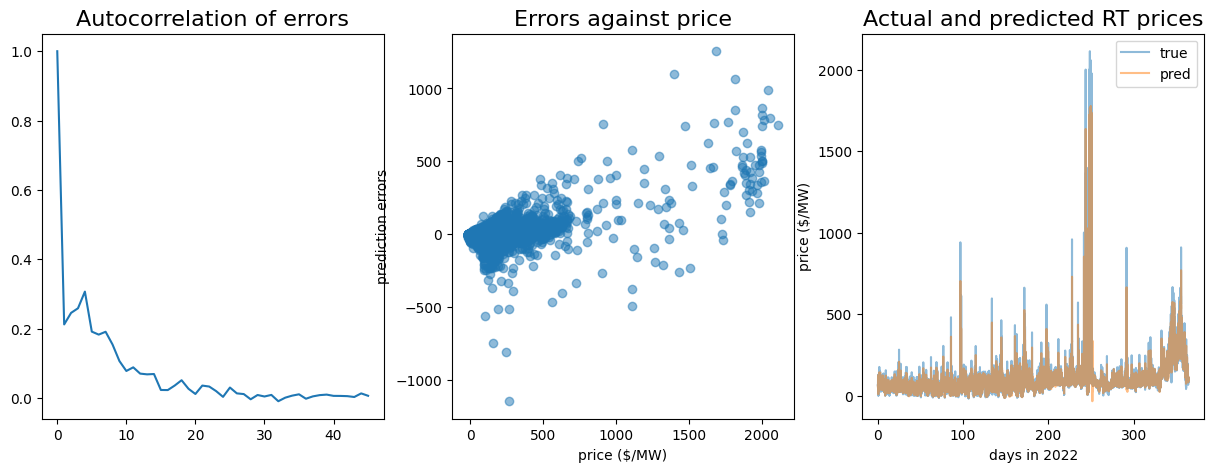

In [55]:
# train model
plot_ts_model(tmodel, X_val, y_val, t=35000)

In [50]:
print(tmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     3914.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:24:30   Log-Likelihood:            -3.2620e+05
No. Observations:               70073   AIC:                         6.525e+05
Df Residuals:                   70022   BIC:                         6.530e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
lmp_rt_m1                 0.68

### 100hr

In [42]:
ymodel = sm.OLS(endog=y_tt, exog=X_tt).fit(disp=0)
yhat_val = ymodel.predict(X_val).values
ace, revenue = test_valueit_model(X_val, y_val, yhat_val, Utheta, hp_optimal[:2], b_params, verbose=True)

test: 100%|██████████████████████████████| 35035/35035 [01:10<00:00, 497.42it/s]


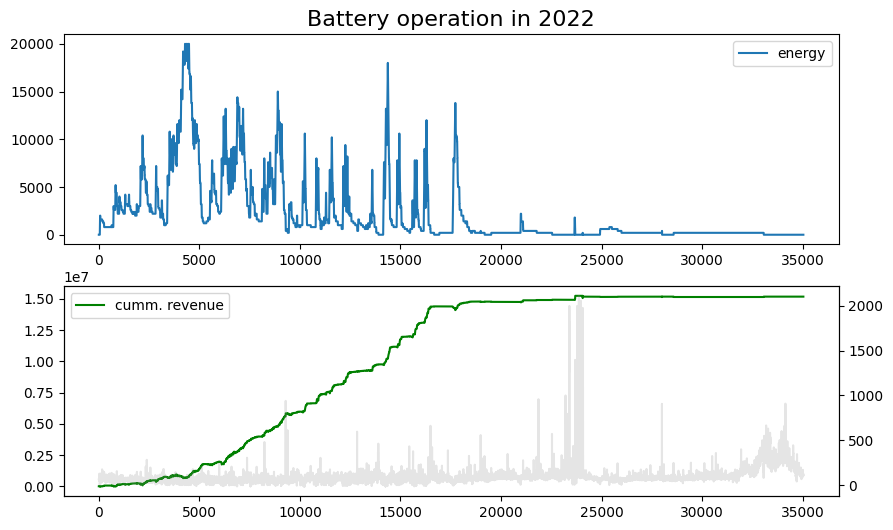

In [43]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
ax1r = ax[1].twinx()
ax[0].plot(ace[2], label='energy')
ax1r.plot(y_val, color='grey', alpha=0.2)
ax[1].plot(np.cumsum(revenue), label='cumm. revenue', color='green')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Battery operation in 2022')
plt.show()

In [47]:
# save Utheta
pd.DataFrame(Utheta).to_csv(f'{PATH_RESULTS}Utheta_{node.lower()}_{b_params["dur"]}.csv', index=False)